In [548]:
# importamos las librerías que necesitamos
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Evaluar linealidad de las relaciones entre las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest
from itertools import combinations

In [513]:
# Leer CSV 2
df2 = pd.read_csv("Files/Customer Loyalty History.csv")

In [514]:
df2.head()

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


In [515]:
columnas_traducidas2 = {
    'Loyalty Number': 'numero_cliente',
    'Country': 'pais',
    'Province': 'provincia',
    'City': 'ciudad',
    'Postal Code': 'codigo_postal',
    'Gender': 'genero',
    'Education': 'educacion',
    'Salary': 'salario',
    'Marital Status': 'estado_civil',
    'Loyalty Card': 'tarjeta_lealtad',
    'CLV': 'valoracion_cliente',
    'Enrollment Type': 'tipo_inscripcion',
    'Enrollment Year': 'ano_inscripcion',
    'Enrollment Month': 'mes_inscripcion',
    'Cancellation Year': 'ano_cancelacion',
    'Cancellation Month': 'mes_cancelacion'
}
df2.rename(columns= columnas_traducidas2, inplace=True)

In [516]:
df2.head()

,numero_cliente,pais,provincia,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


Vamos a empezar gestionando los nulos viendo el % que tenemos con respecto al resto de datos

In [517]:
df2.isna().sum()/df2.shape[0]*100

numero_cliente         0.000000
pais                   0.000000
provincia              0.000000
ciudad                 0.000000
codigo_postal          0.000000
genero                 0.000000
educacion              0.000000
salario               25.321145
estado_civil           0.000000
tarjeta_lealtad        0.000000
valoracion_cliente     0.000000
tipo_inscripcion       0.000000
ano_inscripcion        0.000000
mes_inscripcion        0.000000
ano_cancelacion       87.650117
mes_cancelacion       87.650117
dtype: float64

Empezamos por el año y mes de cancelación

Como consideramos los Nan de la columna de año y mes como que no se han dado de baja, vamos a generar una columna que diga si el cliente esta activo o no y luego sustituirlos por 9999 en el caso del año y 99 en el caso de los . Tambien cambiamos el tipo de dato a int al sustituir los Nan

In [518]:
df2["estado_cliente"] = df2["ano_cancelacion"].apply(lambda x: "Activo" if pd.isna(x) else 'Cancelado')

In [519]:
print(f"El numero de nulos en año de cancelacion antes de convertirlos es {df2['ano_cancelacion'].isna().sum()}")
df2["ano_cancelacion"] = df2["ano_cancelacion"].fillna(9999).astype(int)
print(f"El numero de nulos en año de cancelacion después de convertirlos es {df2['ano_cancelacion'].isna().sum()}")

El numero de nulos en año de cancelacion antes de convertirlos es 14670
El numero de nulos en año de cancelacion después de convertirlos es 0


In [520]:
print(f"El numero de nulos mes de cancelacion antes de convertirlos es {df2['mes_cancelacion'].isna().sum()}")
df2["mes_cancelacion"] = df2["mes_cancelacion"].fillna(99).astype(int)
print(f"El numero de nulos mes de cancelacion después de convertirlos es {df2['mes_cancelacion'].isna().sum()}")

El numero de nulos mes de cancelacion antes de convertirlos es 14670
El numero de nulos mes de cancelacion después de convertirlos es 0


Comprobamos y ahora no tenemos nulos en esas dos columnas. 

Vamos investigar la del salario pero primero veremos esos valores negativos

In [521]:
df2[df2["salario"]<0].shape

(20, 17)

In [522]:
df2[df2["salario"]<0].head(10)

,numero_cliente,pais,provincia,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion,estado_cliente
1082,542976,Canada,Quebec,Montreal,H2Y 4R4,Male,High School or Below,-49830.0,Divorced,Star,24127.50,2018 Promotion,2018,3,9999,99,Activo
1894,959977,Canada,British Columbia,Vancouver,V5R 1W3,Female,Bachelor,-12497.0,Married,Aurora,9453.00,2018 Promotion,2018,3,9999,99,Activo
2471,232755,Canada,British Columbia,Vancouver,V1E 4R6,Female,Bachelor,-46683.0,Single,Nova,4787.81,2018 Promotion,2018,3,9999,99,Activo
3575,525245,Canada,British Columbia,Victoria,V10 6T5,Male,Bachelor,-45962.0,Married,Star,2402.33,2018 Promotion,2018,3,9999,99,Activo
3932,603070,Canada,British Columbia,West Vancouver,V6V 8Z3,Female,Bachelor,-19325.0,Single,Star,2893.74,2018 Promotion,2018,3,9999,99,Activo
4712,491242,Canada,British Columbia,Dawson Creek,U5I 4F1,Male,Bachelor,-43234.0,Married,Star,7597.91,2018 Promotion,2018,3,9999,99,Activo
6560,115505,Canada,Newfoundland,St. John's,A1C 6H9,Male,Bachelor,-10605.0,Married,Nova,5860.17,2018 Promotion,2018,4,9999,99,Activo
6570,430398,Canada,Newfoundland,St. John's,A1C 6H9,Male,Bachelor,-17534.0,Married,Nova,49423.80,2018 Promotion,2018,3,9999,99,Activo
7373,152016,Canada,Ontario,Toronto,P1J 8T7,Female,Bachelor,-58486.0,Married,Aurora,5067.21,2018 Promotion,2018,2,9999,99,Activo
8576,194065,Canada,Ontario,Sudbury,M5V 1G5,Female,Bachelor,-31911.0,Married,Nova,2888.85,2018 Promotion,2018,2,9999,99,Activo


Tenemos 20 clientes con valores negativos. Como hay valores negativos sin importar la educacion. Vamos a comparar el salario dependiendo de la educacion para ver si podemos sacar la conclusión de que es un error y si es asi cambiarlos a posiivos

In [523]:
df2.groupby("educacion")["salario"].describe()

,count,mean,std,min,25%,50%,75%,max
educacion,,,,,,,,
Bachelor,10475.0,72451.061575,17207.352107,-58486.0,58711.00,71960.0,85808.0,105563.0
College,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Doctor,734.0,178608.897820,70466.188750,48109.0,124768.00,182143.5,236612.0,407228.0
High School or Below,782.0,61071.718670,12733.501155,-49830.0,52151.25,61915.0,71384.5,93875.0
Master,508.0,103757.848425,17527.938162,56414.0,88120.00,105487.0,118530.0,133080.0


Vemos que la educacion College tiene todo Nan, esto nos hace pensar que todos los que tienen nan en el salario corresponden a ese grupo de educacion. 

In [524]:
grupo_college = df2[df2["educacion"] == "College"]

In [525]:
grupo_college.isna().sum()/df2.shape[0]*100

numero_cliente         0.000000
pais                   0.000000
provincia              0.000000
ciudad                 0.000000
codigo_postal          0.000000
genero                 0.000000
educacion              0.000000
salario               25.321145
estado_civil           0.000000
tarjeta_lealtad        0.000000
valoracion_cliente     0.000000
tipo_inscripcion       0.000000
ano_inscripcion        0.000000
mes_inscripcion        0.000000
ano_cancelacion        0.000000
mes_cancelacion        0.000000
estado_cliente         0.000000
dtype: float64

Vamos a comprobar que el resto de grupos no tienen Nan

In [526]:
resto_grupos = df2[df2["educacion"] != "College"]

In [527]:
resto_grupos.isna().sum()

numero_cliente        0
pais                  0
provincia             0
ciudad                0
codigo_postal         0
genero                0
educacion             0
salario               0
estado_civil          0
tarjeta_lealtad       0
valoracion_cliente    0
tipo_inscripcion      0
ano_inscripcion       0
mes_inscripcion       0
ano_cancelacion       0
mes_cancelacion       0
estado_cliente        0
dtype: int64

Vamos a continuar con la investigación de los valores negativos

In [528]:
salarios_negativos = df2[df2["salario"]<=0]

In [529]:
salarios_positivos = df2[df2["salario"]>0]

In [530]:
salarios_negativos.groupby("educacion")["salario"].describe()

,count,mean,std,min,25%,50%,75%,max
educacion,,,,,,,,
Bachelor,19.0,-34786.052632,16080.943973,-58486.0,-46576.5,-39503.0,-19328.5,-9081.0
High School or Below,1.0,-49830.000000,NaN,-49830.0,-49830.0,-49830.0,-49830.0,-49830.0


In [531]:
salarios_positivos.groupby("educacion")["salario"].describe()

,count,mean,std,min,25%,50%,75%,max
educacion,,,,,,,,
Bachelor,10456.0,72645.926262,16590.634159,15609.0,58715.5,72026.0,85848.0,105563.0
Doctor,734.0,178608.897820,70466.188750,48109.0,124768.0,182143.5,236612.0,407228.0
High School or Below,781.0,61213.718310,12106.260467,21853.0,52209.0,61928.0,71398.0,93875.0
Master,508.0,103757.848425,17527.938162,56414.0,88120.0,105487.0,118530.0,133080.0


Como los datos estan comprendidos entre los rangos salariales de sus categorias vamos a pasarlos a positivo

In [532]:
def convertir_positivo(valor):
    if pd.isna(valor):
        return valor 
    if valor < 0:
        return abs(valor)
    else:
        return valor
    

In [533]:
df2["salario"] = df2["salario"].apply(convertir_positivo)

In [534]:
# def convertir_datos_negativos(valor):
#     if valor < 0:
#         return 72026.0
#     else:
#         return valor
# df2["salario"] = df2["salario"].apply(convertir_datos_negativos)
# df2.groupby("educacion")["salario"].describe()

Hice esta función para considerar los valores negativos como errores y tratarlos como Nan, ya que de los 20 valores negativos 19 son del grupo Bachelor les introduje la media a esos valores pero el resultado en la media y en la mediana no son relevantes

In [535]:
df2[df2["salario"]<=0].shape

(0, 17)

In [536]:
df2.groupby(["educacion"])["salario"].describe().sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
educacion,,,,,,,,
High School or Below,782.0,61199.161125,12105.354128,21853.0,52151.25,61915.0,71384.5,93875.0
Bachelor,10475.0,72577.254415,16667.023853,9081.0,58711.00,71960.0,85808.0,105563.0
Master,508.0,103757.848425,17527.938162,56414.0,88120.00,105487.0,118530.0,133080.0
Doctor,734.0,178608.897820,70466.188750,48109.0,124768.00,182143.5,236612.0,407228.0
College,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [537]:
print(df2["salario"].median())
print(df2["salario"].mean())

73455.0
79359.34090727258


No es correcto usar la media ni la median de los salarios ya que son superiores a Bachelor y sepor el patrón College debe de tener una media y mediana entre High School y Bachelor

In [538]:
media_high_school = df2.groupby("educacion")["salario"].describe().sort_values(by="mean").loc["High School or Below","mean"]
media_bachelor = df2.groupby("educacion")["salario"].describe().sort_values(by="mean").loc["Bachelor","mean"]
mediana_high_school = df2.groupby("educacion")["salario"].describe().sort_values(by="mean").loc["High School or Below","50%"]
mediana_bachelor = df2.groupby("educacion")["salario"].describe().sort_values(by="mean").loc["Bachelor","50%"]

Otra forma de sacar las medias y medianas

In [539]:
bachelor_media = df2[df2["educacion"]=="Bachelor"]["salario"].mean()
bachelor_mediana = df2[df2["educacion"]=="Bachelor"]["salario"].median()
high_school_media = df2[df2["educacion"]=="High School or Below"]["salario"].mean()
high_school_mediana = df2[df2["educacion"]=="High School or Below"]["salario"].median()

In [540]:
media_college = (bachelor_media + high_school_media) / 2
media_college

66888.20777029707

In [541]:
media_college_mediana = (bachelor_mediana + high_school_mediana) / 2
media_college_mediana

66937.5

No hay mucha diferencia entre la media y la mediana de ambos colectivos por lo que usaremos la mediana para estimar el salario de los que han estudiado College

In [542]:
df2["salario"].fillna(media_college_mediana, inplace=True)

In [543]:
df2.isna().sum()

numero_cliente        0
pais                  0
provincia             0
ciudad                0
codigo_postal         0
genero                0
educacion             0
salario               0
estado_civil          0
tarjeta_lealtad       0
valoracion_cliente    0
tipo_inscripcion      0
ano_inscripcion       0
mes_inscripcion       0
ano_cancelacion       0
mes_cancelacion       0
estado_cliente        0
dtype: int64

## PENDIENTE VER SI HABRIA QUE SACAR LA MEDIA POR CIUDAD EN FUNCION DE LO QUE NOS PIDAN EN EL EJERCICIO

In [544]:
df2.groupby(["educacion","provincia"])["salario"].describe().sort_values(by="mean")

count           mean  \
educacion            provincia                                     
High School or Below Prince Edward Island     3.0   44481.666667   
                     Manitoba                36.0   59157.111111   
                     Alberta                 57.0   60647.982456   
                     Ontario                257.0   60861.089494   
                     British Columbia       198.0   61157.616162   
                     Newfoundland            11.0   61542.181818   
                     Quebec                 154.0   61601.759740   
                     Nova Scotia             22.0   63068.818182   
                     Yukon                    3.0   63445.000000   
                     New Brunswick           24.0   64332.541667   
                     Saskatchewan            17.0   64807.941176   
College              Saskatchewan           106.0   66937.500000   
                     Quebec                 824.0   66937.500000   
                     Prince Edward Island    19.0   66937.500000   
                     Ontario               1387.0   66937.500000   
                     Nova Scotia            111.0   66937.500000   
                     Yukon                   31.0   66937.500000   
                     New Brunswick          146.0   66937.500000   
                     Manitoba               168.0   66937.500000   
                     British Columbia      1135.0   66937.500000   
                     Alberta                244.0   66937.500000   
                     Newfoundland            67.0   66937.500000   
Bachelor             Yukon                   68.0   68814.250000   
                     Newfoundland           161.0   71126.006211   
                     New Brunswick          407.0   71867.641278   
                     Manitoba               407.0   72201.331695   
                     Quebec                2070.0   72351.713527   
                     Alberta                605.0   72518.753719   
                     Ontario               3357.0   72633.381293   
                     British Columbia      2749.0   72828.445253   
                     Nova Scotia            352.0   73102.923295   
                     Saskatchewan           259.0   73205.131274   
                     Prince Edward Island    40.0   77752.600000   
Master               Prince Edward Island     2.0   97444.000000   
                     Newfoundland            12.0  102103.000000   
                     British Columbia       130.0  102675.984615   
                     Nova Scotia             15.0  103219.066667   
                     Ontario                170.0  103589.370588   
                     Quebec                  95.0  103630.273684   
                     Saskatchewan            13.0  104615.923077   
                     Alberta                 32.0  104833.250000   
                     Manitoba                17.0  105283.647059   
                     New Brunswick           20.0  109536.400000   
                     Yukon                    2.0  121204.500000   
Doctor               Saskatchewan            14.0  151863.285714   
                     Manitoba                30.0  157946.933333   
                     Nova Scotia             18.0  160885.333333   
                     Newfoundland             7.0  166762.714286   
                     Alberta                 31.0  167966.645161   
                     Ontario                233.0  177617.879828   
                     British Columbia       197.0  182246.609137   
                     New Brunswick           39.0  182500.512821   
                     Prince Edward Island     2.0  182555.000000   
                     Quebec                 157.0  183902.515924   
                     Yukon                    6.0  220220.500000   

                                                    std       min        25%  \
educacion            provincia                                                 
High Sc

In [545]:
df2[df2["educacion"] == "College"].groupby("provincia").count()

,numero_cliente,pais,ciudad,codigo_postal,genero,educacion,salario,estado_civil,tarjeta_lealtad,valoracion_cliente,tipo_inscripcion,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion,estado_cliente
provincia,,,,,,,,,,,,,,,,
Alberta,244,244,244,244,244,244,244,244,244,244,244,244,244,244,244,244
British Columbia,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135,1135
Manitoba,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168
New Brunswick,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146,146
Newfoundland,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
Nova Scotia,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111,111
Ontario,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387,1387
Prince Edward Island,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
Quebec,824,824,824,824,824,824,824,824,824,824,824,824,824,824,824,824


### CORRELACIONES

In [549]:
numericas = df2.select_dtypes(include = np.number).columns
combinaciones = list(combinations(numericas, 2))

In [547]:
# creamos una función para identificar si las relaciones entre las variables son lienales o no
def identificar_linealidad (dataframe, lista_combinacion_columnas):
    """
    Identifica si las relaciones entre pares de variables en un DataFrame son lineales o no.

    Parameters:
    -----------
    dataframe : pandas.DataFrame
        El DataFrame que contiene las variables a analizar.

    lista_combinacion_columnas : list of tuples
        Una lista de tuplas donde cada tupla contiene dos nombres de columnas del DataFrame que se desea analizar.

    Returns:
    --------
    relaciones_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que tienen una relación lineal.

    relaciones_no_lineales : list of tuples
        Una lista de tuplas que contienen los nombres de las columnas que no tienen una relación lineal.

    """
    relaciones_lineales = []
    relaciones_no_lineales = []

    for tupla in lista_combinacion_columnas: 
        # Realizar la prueba de normalidad
        _, p_value1 = kstest(dataframe[tupla[0]], "norm")
        _, p_value2 = kstest(dataframe[tupla[1]], "norm")

        if p_value1 > 0.05 and p_value2 > 0.05:
            relaciones_lineales.append(tupla)
        else:
            relaciones_no_lineales.append(tupla)

    return relaciones_lineales, relaciones_no_lineales

# llamamos a la funcion

lineal, no_lineal = identificar_linealidad(df2, combinaciones)

print(f"Las variables a las que tengamos que aplicar la correlacion de pearson son: {lineal}")
print(f"Las variables a las que tengamos que aplicar la correlacion de spearman son: {no_lineal}")

Las variables a las que tengamos que aplicar la correlacion de pearson son: []
Las variables a las que tengamos que aplicar la correlacion de spearman son: [('numero_cliente', 'salario'), ('numero_cliente', 'valoracion_cliente'), ('numero_cliente', 'ano_inscripcion'), ('numero_cliente', 'mes_inscripcion'), ('numero_cliente', 'ano_cancelacion'), ('numero_cliente', 'mes_cancelacion'), ('salario', 'valoracion_cliente'), ('salario', 'ano_inscripcion'), ('salario', 'mes_inscripcion'), ('salario', 'ano_cancelacion'), ('salario', 'mes_cancelacion'), ('valoracion_cliente', 'ano_inscripcion'), ('valoracion_cliente', 'mes_inscripcion'), ('valoracion_cliente', 'ano_cancelacion'), ('valoracion_cliente', 'mes_cancelacion'), ('ano_inscripcion', 'mes_inscripcion'), ('ano_inscripcion', 'ano_cancelacion'), ('ano_inscripcion', 'mes_cancelacion'), ('mes_inscripcion', 'ano_cancelacion'), ('mes_inscripcion', 'mes_cancelacion'), ('ano_cancelacion', 'mes_cancelacion')]


In [550]:
df_correlaciones = df2.corr( method = "spearman")
df_correlaciones

,numero_cliente,salario,valoracion_cliente,ano_inscripcion,mes_inscripcion,ano_cancelacion,mes_cancelacion
numero_cliente,1.000000,0.002104,-0.007670,0.009051,0.004146,-0.001369,-0.000662
salario,0.002104,1.000000,-0.000814,-0.036976,0.028571,0.001434,0.000998
valoracion_cliente,-0.007670,-0.000814,1.000000,-0.002707,0.010266,-0.005568,-0.005408
ano_inscripcion,0.009051,-0.036976,-0.002707,1.000000,-0.111181,0.022524,0.012553
mes_inscripcion,0.004146,0.028571,0.010266,-0.111181,1.000000,0.041672,0.035429
ano_cancelacion,-0.001369,0.001434,-0.005568,0.022524,0.041672,1.000000,0.994117
mes_cancelacion,-0.000662,0.000998,-0.005408,0.012553,0.035429,0.994117,1.000000


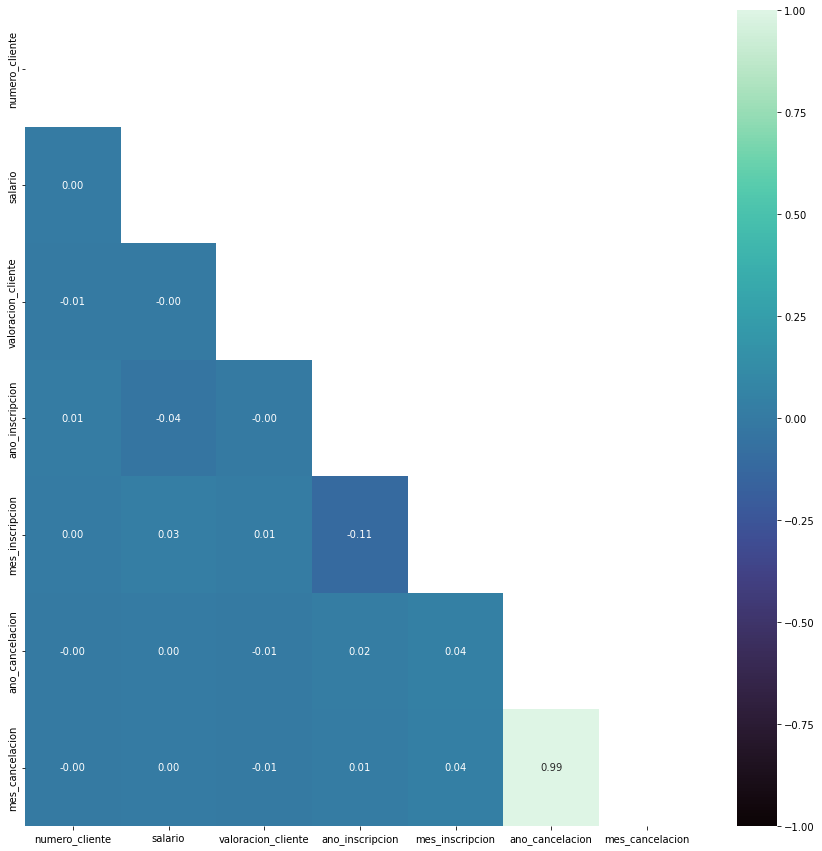

In [551]:
# AHORA YA PODREMOS ENTENDER DE UNA FORMA MÁS AMIGABLE LOS RESULTADOS DE LA MATRIZ DE CORRELACIÓN
# establecemos el tamaño de la gráfica
plt.figure(figsize = (15, 15))

# creamos una matriz booleana de máscara
mask = np.triu(np.ones_like(df_correlaciones, dtype=bool))

# creamos un heatmap con la máscara
sns.heatmap(df_correlaciones, 
            annot = True, 
            fmt = ".2f", 
            cmap = "mako", 
            vmax = 1, 
            vmin = -1, 
            mask = mask); 

In [552]:
df2.to_csv("Files/Customer Loyalty History_limpio.csv", index=False)